# Process 202405 Bathymetry

Based on `tools/bathymetry/Process202108Bathymetry.ipynb` notebook.

Base bathymetry was created in the
https://github.com/SalishSeaCast/analysis-doug/blob/main/notebooks/2xrez-202111/bathymetry-202405.ipynb
notebook by following Michael's process.
Its major differences from the 202108 bathymetry are:
* Changed the Pitt River to be a short, closed stub
* Changed the proxy Fraser River extension to go southward instead of northward,
  and to start just east of the mouth of the Pitt River instead of from the Pitt

Processing steps:
1. Straighten Channel at North Open Boundary
2. Straighten Channel at West Open Boundary
3. Check continuity and Add Mixed Islands
    1. Fix Puget Sound
4. Smooth
    1. Extra smooth Puget Sounnd
5. Add shallow Steeveston Jetty
6. Check dredged Fraser River Channel
7. Check continuity and fix islands:
    1. connect Roche Harbour
    2. remove extra little island on mudflats
    3. don't close north of Read Island
    4. Disconnect Stuart Island
    5. Deepen Tacoma Narrows
8. Plot up our Final Bathymetry
9. Write out bathy file and jetty extra friction files


In [1]:
from pathlib import Path
import sys

import cmocean.cm as cm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import bathy_tools, nc_tools, viz_tools

import matplotlib.colors as matcolors
import matplotlib.cm as cmx

Python and library versions:

In [2]:
import bottleneck
import cmocean
import h5netcdf
import h5py
import matplotlib
import netCDF4
import numpy
import pandas
import scipy
import xarray

print(f"Python {sys.version=}")
print(f"{numpy.__version__=}")
print(f"{xarray.__version__=}")
print(f"{bottleneck.__version__=}")
print(f"{pandas.__version__=}")
print(f"{h5netcdf.__version__=}")
print(f"{h5py.__version__=}")
print(f"{netCDF4.__version__=}")
print(f"{scipy.__version__=}")
print(f"{matplotlib.__version__=}")
print(f"{cmocean.__version__=}")

Python sys.version='3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]'
numpy.__version__='1.26.4'
xarray.__version__='2024.6.0'
bottleneck.__version__='1.4.0'
pandas.__version__='2.2.2'
h5netcdf.__version__='1.3.0'
h5py.__version__='3.11.0'
netCDF4.__version__='1.6.5'
scipy.__version__='1.14.0'
matplotlib.__version__='3.8.4'
cmocean.__version__='v3.0.3'


## Load, Plot and `depth_check()` the Bathymetry

In [3]:
# isolate the probable user-specific part of repo paths to make the notebook portable
repos_prefix = Path("/media/doug/warehouse/MEOPAR/")

In [4]:
bathy_paths = {
    "base_202405": repos_prefix / "grid" / "bathymetry_202405_base.nc",
    "final_202405": repos_prefix / "grid" / "bathymetry_202405.nc",
}

In [5]:
with xarray.open_dataset(bathy_paths["base_202405"], engine="h5netcdf") as bathy:
    lons = bathy.nav_lon
    lats = bathy.nav_lat
    base_bathy = bathy.Bathymetry

Calculate expanded `lons` and `lats` arrays by extrapolating values on south and east edges.
This provides arrays that `pcoulormesh()` interprets as cell edges so that it doesn't a
`UserWarning` about the non-montonic lon/lat values that arise due to the rotated grid.
This code is based on Michael's `expandf()` function in
https://github.com/SalishSeaCast/analysis-michael/blob/master/bathymetry/bathy_helpers.py

In [6]:
lons_e = numpy.zeros((lons.shape[0]+1, lons.shape[1]+1))
lons_e[1:, 1:] = lons
lons_e[0, 1:] = lons[0, :] - (lons[1, :] - lons[0, :])
lons_e[:, 0] = lons_e[:, 1] - (lons_e[:, 2] - lons_e[:, 1])

lats_e = numpy.zeros((lats.shape[0]+1, lats.shape[1]+1))
lats_e[1:, 1:] = lats
lats_e[0, 1:] = lats[0, :] - (lats[1, :] - lats[0, :])
lats_e[:, 0] = lats_e[:, 1] - (lats_e[:, 2] - lats_e[:, 1])

Plotting setup:

In [7]:
cmap = cm.deep
cmap.set_bad('darkgreen')
lon_limits = (47, 51)
lat_limits = (-126.3, -122.2)
y_max = base_bathy.y.max().item() + 1
x_max = base_bathy.x.max().item() + 1
cNorm  = matcolors.Normalize(vmin=0, vmax=14)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='cool')

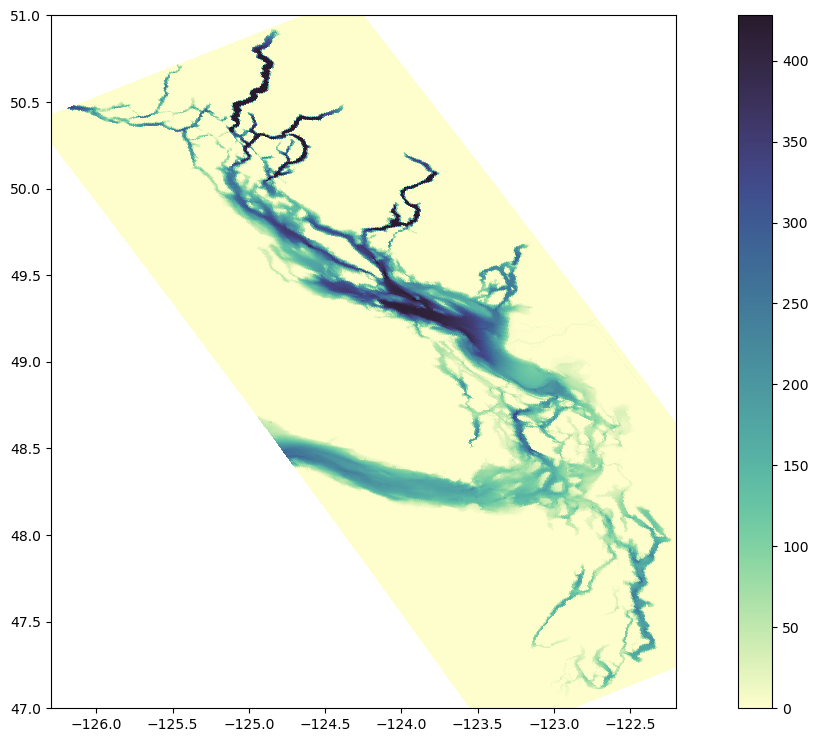

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lons_e, lats_e, base_bathy, cmap=cmap)
fig.colorbar(mesh, ax=ax)

In [9]:
def depth_check(bathy):
    """Checks the depth at each point of the bathymetric data and prints
    whether it is "Deep" or "Shallow".

    A depth greater than 428 is considered "Deep" and a depth between 0
    and 4 (non-inclusive) is considered "Shallow". The function iterates
    through the entire 2D array of bathymetric data to classify each point.

    :param bathy: 2D array of bathymetric data where each element represents
                  the depth at that point
    :type bathy: numpy.ndarray

    :return: None
    """
    DEEP_DEPTH_THRESHOLD = 428
    SHALLOW_DEPTH_UPPER_THRESHOLD = 4
    SHALLOW_DEPTH_LOWER_THRESHOLD = 0

    # Utility function to encapsulate repeating depth info printing
    def print_depth_info(mask, label, base_bathy):
        for y in mask.y:
            for x in mask.x:
                if mask[y, x]:
                    print(
                        f"{label}: y={y.item()}, x={x.item()}, depth={base_bathy[y, x].item()}"
                    )

    # Identify deep and shallow areas
    deep_mask = bathy > DEEP_DEPTH_THRESHOLD
    shallow_mask = numpy.logical_and(
        base_bathy < SHALLOW_DEPTH_UPPER_THRESHOLD,
        base_bathy > SHALLOW_DEPTH_LOWER_THRESHOLD
    )

    # Handle deep areas
    if deep_mask.any():
        print_depth_info(deep_mask, "Deep", base_bathy)

    # Handle shallow areas
    if shallow_mask.any():
        print_depth_info(shallow_mask, "Shallow", base_bathy)


In [10]:
depth_check(base_bathy)

## Straighten Channel at North Open Boundary

Change the shape of Johnstone Strait at the north boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [11]:
ns_bathy = base_bathy.copy()
js = 37  # x index to start changes at
je = 75  # x index to end changes at

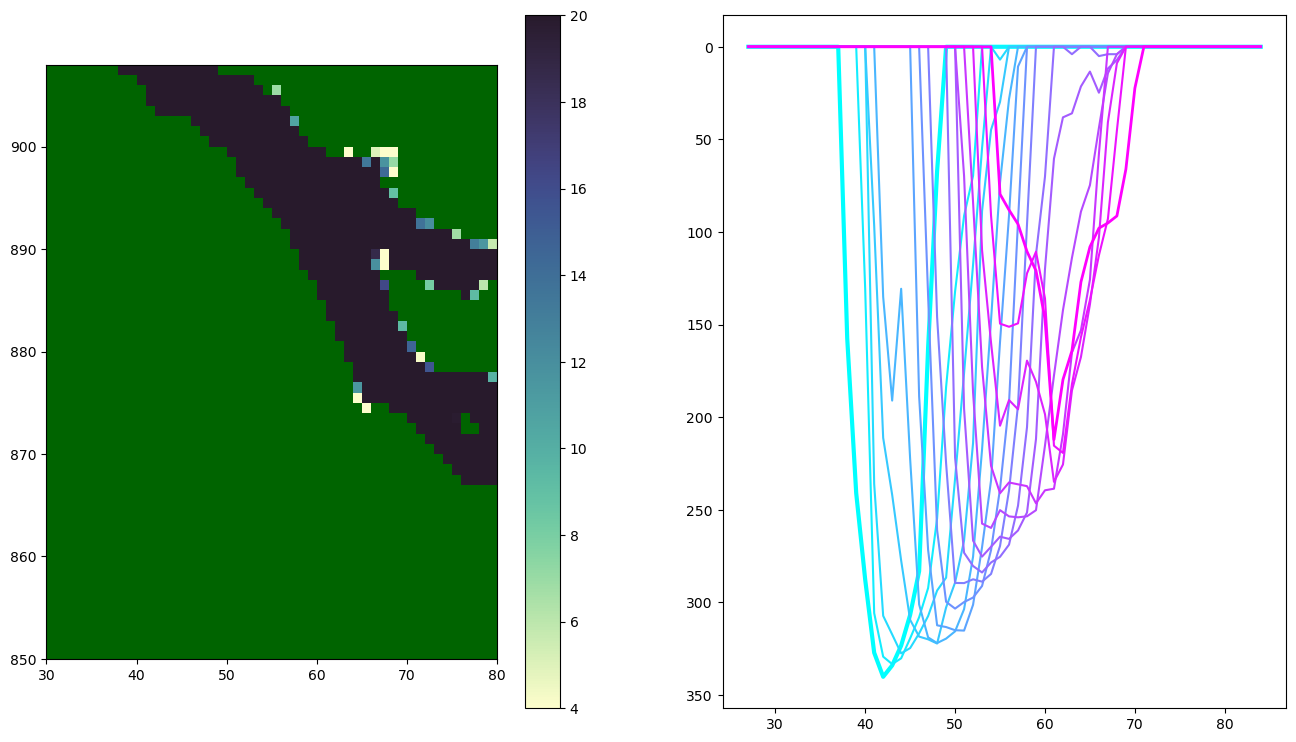

In [12]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)


def plot_north_bdy(ns_masked, y_max):
    fig, (ax_plan, ax_depth) = plt.subplots(1, 2, figsize=(16, 9))
    ax_plan.set_ylim((850, y_max))
    ax_plan.set_xlim((30, 80))
    viz_tools.set_aspect(ax_plan)
    mesh = ax_plan.pcolormesh(ns_masked, cmap=cmap, vmax=20)
    fig.colorbar(mesh, ax=ax_plan)
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1, js - 10:je + 10],
                  color=scalarMap.to_rgba(0), linewidth=3)
    for i in range(1, 14):
        ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - i, js - 10:je + 10],
                      color=scalarMap.to_rgba(i))
    ax_depth.plot(range(js - 10, je + 10), ns_bathy[y_max - 1 - 14, js - 10:je + 10],
                  color=scalarMap.to_rgba(14), linewidth=2)
    ax_depth.invert_yaxis()


plot_north_bdy(ns_masked, y_max)

In [13]:
init_north = np.array(base_bathy[y_max-1, :])
# shift north bathymetry 7 points west
north = np.zeros_like(init_north)
north[js:je] = init_north[js-7:je-7]

#first 6 grid points (0-5) use the same, core profile shifted east.  After that merge into the original
#bathymetry, shifting South by half a grid point per grid point east.

# Closest 5 rows to northern boundary, all the same as the boundary
for i in range(y_max-5, y_max):
    ns_bathy[i, js:je] = north[js:je]
# Now move away from the boundary, blending

i=5; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js:je] + (i-5)/10.*ns_bathy[ii, js:je]
i=6; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-1:je-1] + (i-5)/10.*ns_bathy[ii, js:je]
i=7; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-2:je-2] + (i-5)/10.*ns_bathy[ii, js:je]
i=8; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-3:je-3] + (i-5)/10.*ns_bathy[ii, js:je]
i=9; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-4:je-4] + (i-5)/10.*ns_bathy[ii, js:je]
i=10; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-5:je-5] + (i-5)/10.*ns_bathy[ii, js:je]
i=11; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-6:je-6] + (i-5)/10.*ns_bathy[ii, js:je]
i=12; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-7:je-7] + (i-5)/10.*ns_bathy[ii, js:je]
i=13; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-8:je-8] + (i-5)/10.*ns_bathy[ii, js:je]
i=14; ii=y_max-1-i
ns_bathy[ii, js:je] = (-i+15)/10.*north[js-9:je-9] + (i-5)/10.*ns_bathy[ii, js:je]

In [14]:
# Remove shallow points, deepen points almost at 4
for i in range(880,y_max):
    for j in range(30,80) :
        if ns_bathy[i, j] < 2:
            ns_bathy[i, j] = 0
        elif ns_bathy[i, j] < 4:
            ns_bathy[i, j] = 4

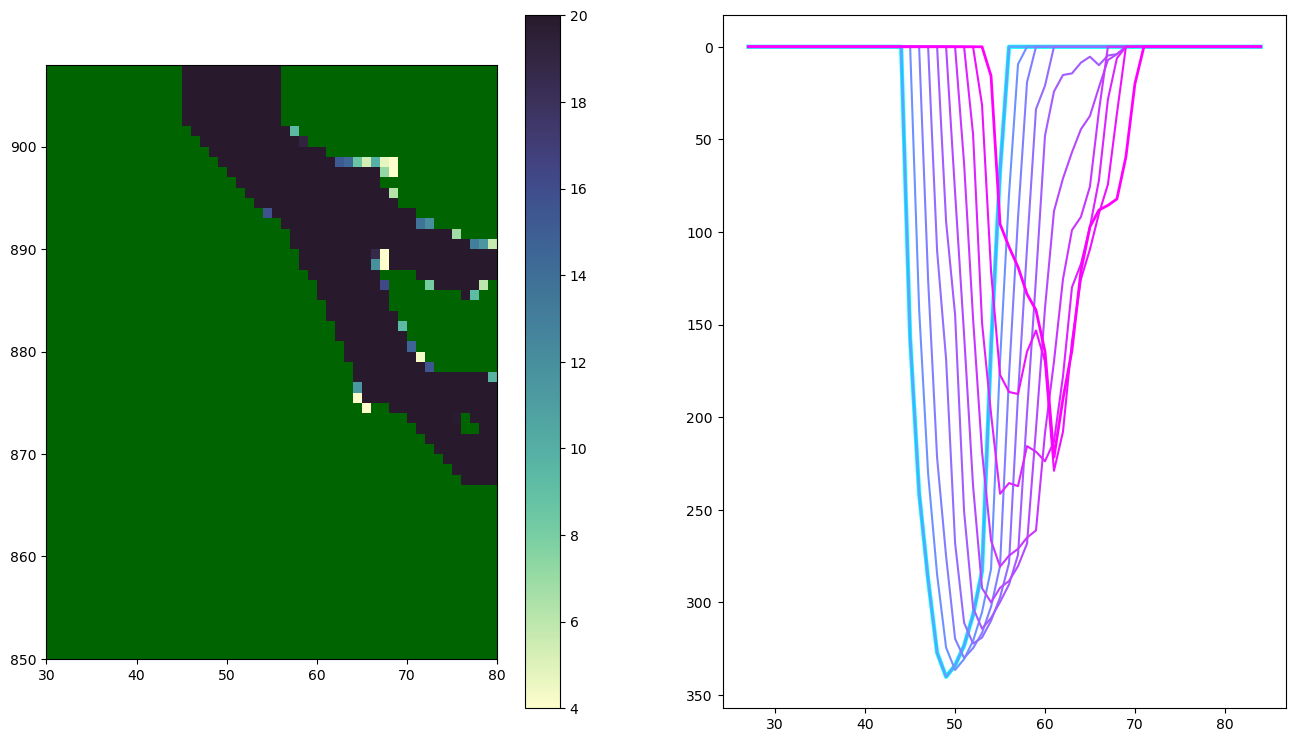

In [15]:
ns_masked = np.ma.masked_array(ns_bathy, ns_bathy == 0)
plot_north_bdy(ns_masked, y_max)

depth_check(ns_masked)

## Straighten Channel at West Open Boundary

Change the shape of Jua de Fuca Strait at the west boundary of the grid to make it perpendicular to the grid edge.
This is done to avoid numerical instabilities.

In [16]:
ws_bathy = ns_bathy.copy()
iss = 360  # y index to start changes at
iee = 480  # y index to end changes at

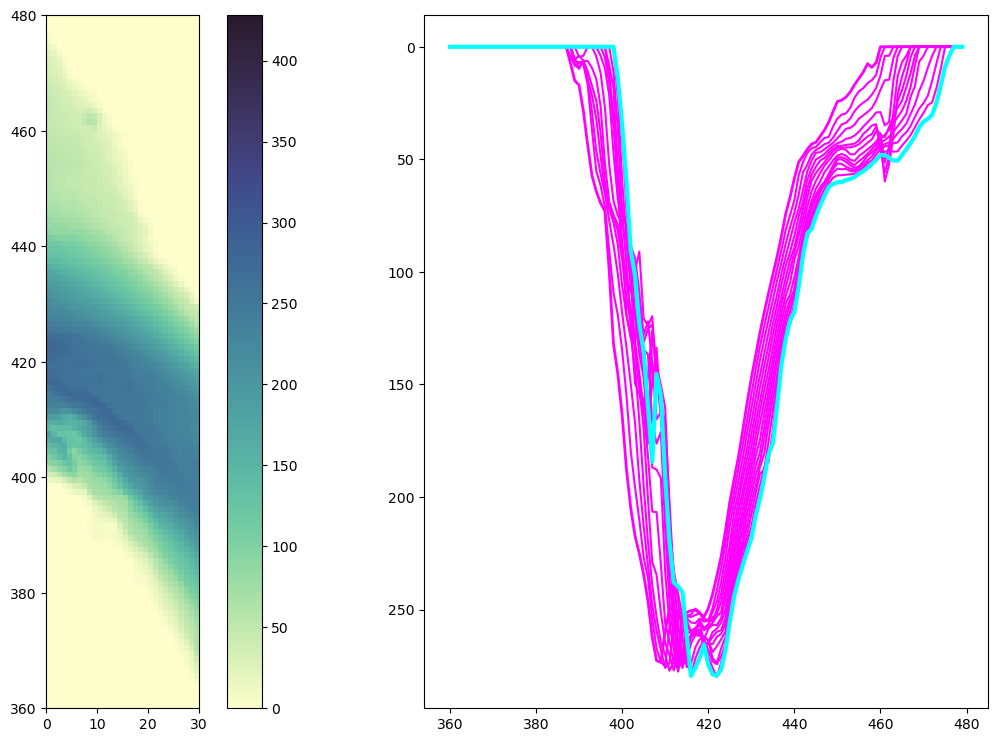

In [17]:
def plot_west_bdy(ws_bathy, iss, iee):
    fig, (ax_plan, ax_depth) = plt.subplots(1, 2, figsize=(16, 9))
    ax_plan.set_ylim((iss, iee))
    ax_plan.set_xlim((0, 30));
    viz_tools.set_aspect(ax_plan)
    mesh = ax_plan.pcolormesh(ws_bathy, cmap=cmap)
    fig.colorbar(mesh, ax=ax_plan)

    for j in range(1, 14):
        ax_depth.plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
    ax_depth.plot(
        range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2
    )
    ax_depth.plot(
        range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3
    )
    ax_depth.invert_yaxis()

plot_west_bdy(ws_bathy, iss, iee)

Unlike the North, the mouth profile is kind of jagged.

  A. We'll take out the bank to the south by rearranging the profile and

  B. We'll rearrange the depths in the centre, so that they are a simple up and down: i.e. make the two deep channels into one. At the same time, move the deepest point, one point to the south. This emphasizes the southern channel, which is the channel that continues into Juan de Fuca. We do this so there is no artifical sill in this channel which is not seen in the original bathymetry.

In [18]:
core = ws_bathy.isel(x=0).copy()
print(core[iss+43:iss+53].values)

[101.66333008 123.25875854 135.02902052 159.55469259 184.36438497
 145.40374451 155.01451874 191.34469096 220.07521057 238.04792531]


In [19]:
# A. remove bank
core[iss+46] = ws_bathy[iss+48,0]
core[iss+47] = ws_bathy[iss+49,0]
core[iss+48] = ws_bathy[iss+46,0]
core[iss+49] = ws_bathy[iss+47,0]
print(core[iss+43:iss+53].values)

[101.66333008 123.25875854 135.02902052 145.40374451 155.01451874
 159.55469259 184.36438497 191.34469096 220.07521057 238.04792531]


In [20]:
print(core[411:430].values)

[220.07521057 238.04792531 239.73733351 242.15959676 261.67866177
 279.46614583 275.8232371  271.60856289 265.43810696 274.51956685
 278.7413737  279.39492289 276.5459849  267.96089851 255.51526896
 244.19440884 236.64743296 230.45999908 224.22202131]


In [21]:
# B. Fix central channel
core[412] = ws_bathy[413,0]
core[413] = ws_bathy[415,0]
core[414] = ws_bathy[417,0]
core[415] = ws_bathy[416,0]
core[416] = ws_bathy[422,0]
core[417] = ws_bathy[421,0]
core[418] = ws_bathy[423,0]
core[419] = ws_bathy[420,0]
core[420] = ws_bathy[418,0]
core[421] = ws_bathy[424,0]
core[422] = ws_bathy[419,0]
core[423] = ws_bathy[425,0]
core[424] = ws_bathy[426,0]
core[425] = ws_bathy[414,0]
core[426] = ws_bathy[427,0]
core[427] = ws_bathy[412,0]
print(core[412:427].values)

[239.73733351 261.67866177 275.8232371  279.46614583 279.39492289
 278.7413737  276.5459849  274.51956685 271.60856289 267.96089851
 265.43810696 255.51526896 244.19440884 242.15959676 236.64743296]


In [22]:
print(core[iss+37:iss+40].values)
print(core[iee-4:iee-1].values)


[ 0.          0.         13.97926807]
[4. 0. 0.]


In [23]:
# smooth the west profile, twice
newcore = core
for i in range(iss,iee):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
for i in range(370,510):
    newcore[i] = 0.25*core[i-1] + 0.5*core[i] + 0.25*core[i+1]
core[:] = newcore
# rezero iss+37 and iss+38 as we do not want to expand the domain
core[0:iss+38+1] = 0
# rezero iee-4, iee-3,iee-2 as we do not want to expand the domain
print (core[iee-4:iee].values)
core[iee-3:] = 0
# this domain goes one grid point further north than previous, zero iee-4
core[iee-4] = 0.

[5.01224403 1.87385658 0.62366304 0.1904044 ]


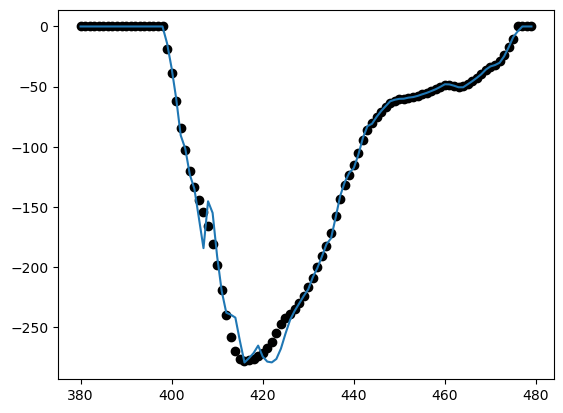

In [24]:
plt.plot(range(380,480), -core[380:480], 'ko', range(380,480), -ws_bathy[380:480,0], '-');

We now have "core" which is the bathymetry at the mouth.  This continues 5 more grid points into the domain.  Beyond that we blend into the original bathymetry linearly over the next 10 grid points.  The only difficulty is that we need to follow the bathymetry south-east, so we need to shift south as we go.

In [25]:
for i in range(0,5):
    ws_bathy[380:480, i] = core[380:480]
i=5
ws_bathy[380:480, i] = (-i+15)/10*core[380:480].values  + (i-5)/10*ws_bathy[380:480, i]
i=6
ws_bathy[380:480, i] = (-i+15)/10*(core[380:480].values + core[381:481].values)/2 + (i-5)/10*ws_bathy[380:480, i]
i=7
ws_bathy[380:480, i] = (-i+15)/10*core[381:481].values + (i-5)/10*ws_bathy[380:480, i]
i=8
ws_bathy[380:480, i] = (-i+15)/10*(core[381:481].values + core[382:482].values)/2 + (i-5)/10*ws_bathy[380:480, i]
i=9
ws_bathy[380:480, i] = (-i+15)/10*core[382:482].values + (i-5)/10*ws_bathy[380:480, i]
i=10
ws_bathy[380:480, i] = (-i+15)/10*(core[382:482].values + core[383:483].values)/2 + (i-5)/10*ws_bathy[380:480, i]
i=11
ws_bathy[380:480, i] = (-i+15)/10*core[383:483].values + (i-5)/10*ws_bathy[380:480, i]
i=12
ws_bathy[380:480, i] = (-i+15)/10*(core[383:483].values + core[384:484].values)/2 + (i-5)/10*ws_bathy[380:480, i]
i=13
ws_bathy[380:480, i] = (-i+15)/10*core[384:484].values + (i-5)/10*ws_bathy[380:480, i]
i=14
ws_bathy[380:480, i] = (-i+15)/10*(core[384:484].values + core[385:485].values)/2 + (i-5)/10*ws_bathy[380:480, i]


In [26]:
# We have introduced depths that are between 0 and 4.  Choose one or the other
for i in range(iss, iee):
    for j in range (50):
        if ws_bathy[i, j] > 0 and ws_bathy[i, j] < 2 :
            print (i, j, ws_bathy[i, j].values, 'low')
            ws_bathy[i, j] = 0
        elif ws_bathy[i, j] >= 2 and ws_bathy[i, j] < 4:
            print (i, j, ws_bathy[i, j].values, 'high')
            ws_bathy[i, j] = 4


388 13 3.2 high
389 9 2.0766401926676434 high
389 10 3.868070363998413 high
389 11 3.798859596252441 high
390 8 1.3600949764251709 low
390 9 3.6679052352905277 high
390 12 2.8 high
391 8 1.2 low
391 9 2.5318662961324057 high
391 10 3.003943125406901 high
391 11 3.9587955474853516 high
392 9 2.5163440704345703 high
393 9 3.7377500534057617 high
394 8 1.2952702522277832 low
395 7 0.8 low
395 8 3.458764362335205 high
396 6 0.46618313789367677 low
396 7 1.9085439682006837 low
397 6 1.5879999160766602 low
464 14 3.783725467439073 high
465 14 3.5099005149231903 high
466 14 3.2856155528392437 high
467 14 3.022808157551424 high
468 14 2.604605320332478 high
469 14 2.009042580845214 high
470 13 3.346814153681164 high
470 14 1.3425158841001505 low
471 13 2.023249382719438 high
471 14 0.5058123456798596 low
472 12 1.5174370370395787 low
473 10 2.5290617283992978 high
474 8 3.5406864197590164 high


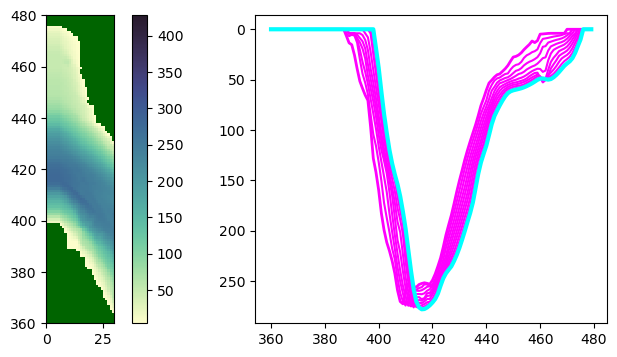

In [27]:
ws_masked = np.ma.masked_array(ws_bathy, ws_bathy == 0)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_masked, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((360, 480))
axs[0].set_xlim((0, 30));

for j in range(1, 14):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()
depth_check(ws_masked[:])

there is too much extra shallow water in the North.  We can't get rid of all of it, it is partially due to the direct Eastward extension of the boundary, but we can crop some.

In [28]:
top=480
bot=450
left = 3
right = 30

ws_bathy[bot+26,3+left:12+left] = 0
ws_bathy[bot+25,5+left:12+left] = 0
ws_bathy[bot+24,6+left:12+left] = 0
ws_bathy[bot+23,7+left:12+left] = 0
ws_bathy[bot+22,8+left:12+left] = 0
ws_bathy[bot+21,9+left:12+left] = 0
ws_bathy[bot+20,10+left:13+left] = 0
ws_bathy[bot+15:bot+20,11+left:13+left] = 0
ws_bathy[bot+11:bot+15,12+left:14+left] = 0


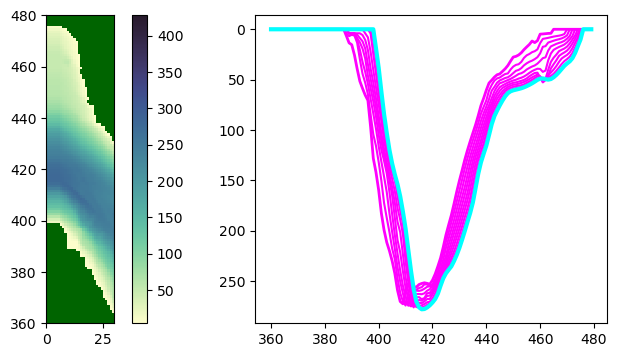

In [29]:
ws_masked = np.ma.masked_array(ws_bathy, ws_bathy == 0)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(ws_masked, cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((360, 480))
axs[0].set_xlim((0, 30));

for j in range(1, 14):
    axs[1].plot(range(iss, iee), ws_bathy[iss:iee, j], color=scalarMap.to_rgba(i))
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 0], color=scalarMap.to_rgba(0), linewidth=3)

axs[1].invert_yaxis()
depth_check(ws_masked[:])

### Fix the bump, centre of so many NaN's ###

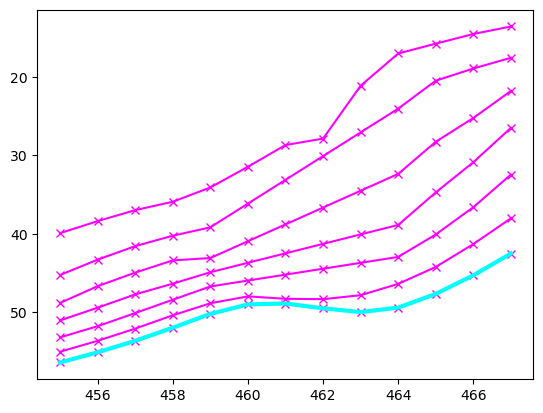

In [30]:
w = 0.2
for i in range(460, 464):
    ip = i-459
    for j in range(7, 11):
        ws_bathy[i, j] =  w*(5-ip)*ws_bathy[459, j] + w*ip*ws_bathy[464, j]
iii, ijj = 455, 468
fig, ax = plt.subplots(1, 1)
for j in range(5, 12):
    ax.plot(range(iii, ijj), ws_bathy[iii:ijj, j], 'x-', color=scalarMap.to_rgba(i))
#axs[1].plot(range(iss, iee), ws_bathy[iss:iee, 14], color=scalarMap.to_rgba(14), linewidth=2)
ax.plot(range(iii, ijj), ws_bathy[iii:ijj, 5], color=scalarMap.to_rgba(0), linewidth=3)

ax.invert_yaxis()

## Check continuity and Add Missed Islands

In [26]:
oc_bathy = np.copy(ws_bathy)

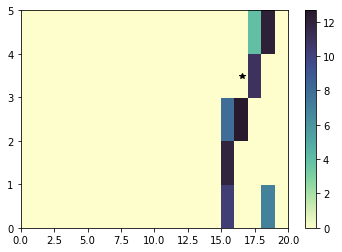

In [27]:
plt.pcolormesh(oc_bathy[35:40, 100: 120], cmap=cmap)
plt.plot(116-100+0.5, 38-35+0.5, 'k*')
plt.colorbar()

oc_bathy[38, 116] = 0.5*(oc_bathy[38, 117] + oc_bathy[37, 116])

In [ ]:
plt.pcolormesh(oc_bathy[140:210, 260:350], cmap=cmap)
plt.plot(318-260+0.5, 194-140+0.5, 'k*')
plt.colorbar();
# Not relevant
#oc_bathy[194, 318] = 0.5*(oc_bathy[193, 318] + oc_bathy[195, 318])

In [ ]:
imin, imax = 250, 280
jmin, jmax = 330, 350
ii, jj = 271, 339
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'k*')
print (oc_bathy[ii, jj])
plt.colorbar();
# not relevant
#oc_bathy[271, 339] = 0.

In [ ]:
imin, imax = 250, 350
jmin, jmax = 200, 280
ii, jj = 319, 249
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'k*')
print (oc_bathy[ii, jj])
plt.colorbar();
# not relevant
# oc_bathy[319, 249] = 0.5*(oc_bathy[318, 249] + oc_bathy[320, 249])

4.189881801605225


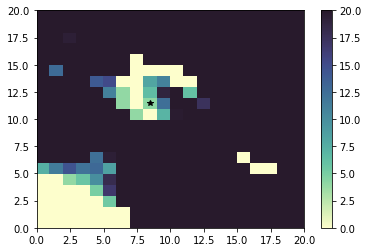

In [28]:
imin, imax = 320, 340
jmin, jmax = 300, 320
ii, jj = 331, 308
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'k*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[331, 308] = 0.

[19.5        10.47832    21.97062913]


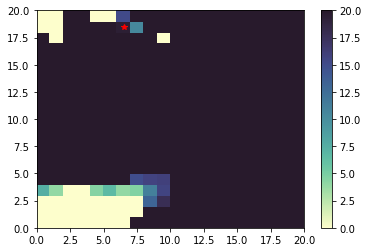

In [29]:
# End of Saturna Island
imin, imax = 330, 350
jmin, jmax = 280, 300
ii, jj = 348, 286
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj:jj+3])
plt.colorbar()
oc_bathy[348, 286:289] = 0.

[34.20848729  7.07451466]


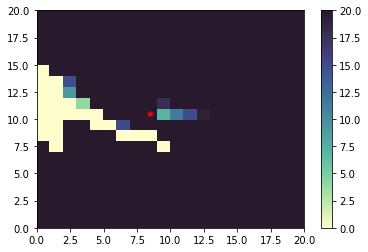

In [30]:
# Tumbo Island
imin, imax = 340, 360
jmin, jmax = 280, 300
ii, jj = 350, 288
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj:jj+2])
plt.colorbar()
oc_bathy[350, 288:290] = 0.
oc_bathy[351, 287:289] = 0.
oc_bathy[352, 286] = 0.
oc_bathy[353, 285] = 0.

[15.65010373 19.81978374]
[7.96354824 7.09524647]
7.63456318113539


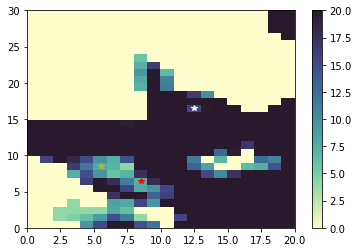

In [31]:
# Russell Island near Fulford Harbour
# Piers Island near Swartz Bay
# Knapp Island near Swartz Bay
imin, imax = 350, 380
jmin, jmax = 220, 240
ii, jj = 366, 232
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'w*')
print (oc_bathy[ii, jj:jj+2])
ii, jj = 358, 225
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'y*')
print (oc_bathy[ii, jj:jj+2])
ii, jj = 356, 228
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[366, 232:234] = 0.
oc_bathy[358, 225:227] = 0
oc_bathy[356, 228] = 0.

[ 4.01945455 10.08857708 11.3837    ]


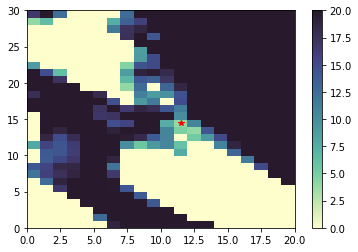

In [32]:
# Samuel Island north end of Saturna
imin, imax = 350, 380
jmin, jmax = 260, 280
ii, jj = 364, 271
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii:ii+3, jj])
plt.colorbar()
oc_bathy[364:367, 271] = 0.
oc_bathy[368, 269] = 0.

In [ ]:
# end of Galiano
imin, imax = 410, 430
jmin, jmax = 230, 250
ii, jj = 428, 240
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar();
# not needed
# oc_bathy[428, 240] = 0.

[4.05913749 5.95162412 7.52014806]


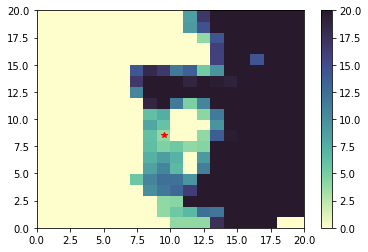

In [33]:
# Newcastle Island
imin, imax = 480, 500
jmin, jmax = 200, 220
ii, jj = 488, 209
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii:ii+3, jj])
plt.colorbar()
oc_bathy[488:491, 209] = 0.

5.094


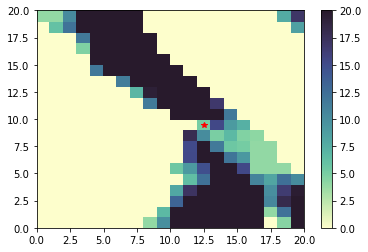

In [34]:
# Mudge Island
imin, imax = 460, 480
jmin, jmax = 210, 230
ii, jj = 469, 222
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[469, 222] = 0.
oc_bathy[468, 223] = 0.
oc_bathy[467, 224] = 0.
oc_bathy[466, 225:227] = 0.
oc_bathy[465, 226] = 0.

[4. 4.]


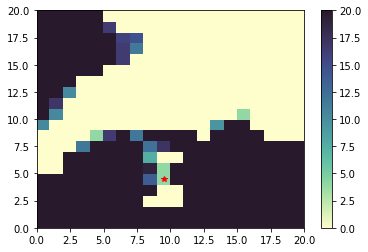

In [35]:
# Twin Islands near Hernando
imin, imax = 720, 740
jmin, jmax = 160, 180
ii, jj = 724, 169
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii:ii+2, jj])
plt.colorbar()
oc_bathy[724:726, 169] = 0.

0.0


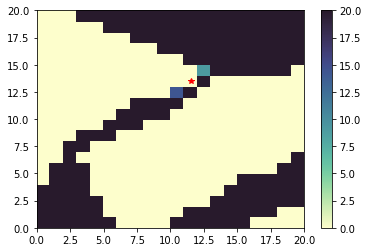

In [36]:
# Between West and East Redondo
imin, imax = 750, 770
jmin, jmax = 210, 230
ii, jj = 763, 221
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[763, 221] = 0.5*(oc_bathy[762, 221] + oc_bathy[763, 222])

0.0


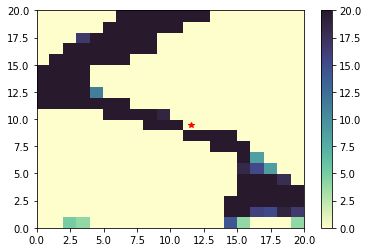

In [37]:
# North of West thurlow
imin, imax = 840, 860
jmin, jmax = 120, 140
ii, jj = 849, 131
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[849, 131] = 0.5*(oc_bathy[849, 130] + oc_bathy[848, 131])

In [ ]:
# Stuart Island (see below)
imin, imax = 790, 830
jmin, jmax = 160, 200
ii, jj = 807, 180
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar();
# not relevent
# oc_bathy[807, 180] = 0.5*(oc_bathy[807, 179] + oc_bathy[808, 180])

202.5658187866211


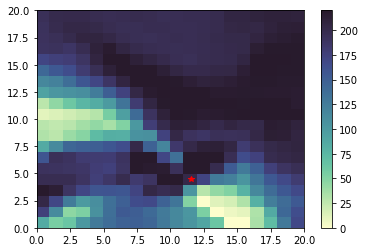

In [38]:
# Boundary Pass Smoothing
imin, imax = 340, 360
jmin, jmax = 290, 310
ii, jj = 344, 301
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=220)
plt.plot(jj-jmin+0.5, ii-imin+0.5, 'r*')
print (oc_bathy[ii, jj])
plt.colorbar()
oc_bathy[344, 301] = 0.5*(oc_bathy[345, 301] + oc_bathy[344, 300])

In [39]:
depth_check(oc_bathy[:])

### 7. Fix Puget

In [40]:
ps_bathy = np.copy(oc_bathy[:])

In [ ]:
# Snohomish river mouth
Fill = [(309,145),(309,144),(310,148),(310,147),(310,146),(310,145),(310,144),(310,143),(310,142),(311,148),(311,147),(311,146),(311,145),(311,144),
        (311,143),(311,142),(311,141),(312,149),(312,148),(312,147),(312,146),(312,145),(312,144),(312,143),(312,142),(312,141),(312,140),(312,138),
        (312,137),(313,149),(313,148),(313,147),(313,146),(313,145),(313,144),(313,143),(313,142),(313,141),(313,140),(313,138),(313,137),(314,146),
        (314,145),(314,144),(314,143),(314,142),(314,141),(314,139),(315,144),(315,143),(315,142),(315,140),(315,139),(316,144),(316,143),(316,141),
        (316,140),(317,144),(317,143),(317,142),(317,141),(313,139),(314,140),(315,141),(316,142),(318,145),(318,144),(318,143),(318,142),(319,145),
        (319,144),(319,143),(319,142),(320,145),(320,144),(320,143),(321,143),(318,141)]
imin, imax = 300, 330
jmin, jmax = 130, 160
ii, jj = 309, 137
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for iii, jjj in Fill:
    plt.plot(jjj-jmin+0.5, iii-imin+0.5, 'w*')
print (oc_bathy[ii, jj])
plt.colorbar()
# don't add this

In [ ]:
#Dabob bay
# Note these are all inverted i j!!!
Fill = [(198,145),(198,146),(197,146),(199,146),(199,147),(198,147),(197,147),(199,148),(200,148),(198,144),(208,149),(209,149),
        (207,149),(236,111),(237,111),(180,127),(180,128),(181,128)]
imin, imax = 100, 160
jmin, jmax = 170, 240
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for jjj,iii in Fill:
    plt.plot(jjj-jmin+0.5, iii-imin+0.5, 'r*')
plt.colorbar()
# don't add this

In [ ]:
# Near Brinnon and Seabeck
# and these are inverted too!
Fill = [(168,119),(167,119),(177,124),(178,124),(179,124),(179,125),(180,125),(180,126),(179,126),(181,112)]
imin, imax = 100, 160
jmin, jmax = 160, 210
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for jjj,iii in Fill:
    plt.plot(jjj-jmin+0.5, iii-imin+0.5, 'r*')
plt.colorbar()
# don't add this

In [ ]:
# North Bay
# and these are inverted too!
Fill = [(150,59),(150,60),(151,60),(151,59),(152,61),(152,62),(151,61),(153,61),(153,62),(153,63),(153,64),(154,64)]
imin, imax = 40, 80
jmin, jmax = 100, 180
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for jjj,iii in Fill:
    plt.plot(jjj-jmin+0.5, iii-imin+0.5, 'r*')
plt.colorbar()
# don't add this

In [41]:
ps_masked = np.ma.masked_array(ps_bathy, ps_bathy == 0)

In [ ]:
# Down towards Skokomish
Fill2 = [(135,100),(134,98),(133,98),(132,97),(131,97),(131,96),(130,96),(129,96),(127,96),(127,95),(126,95),(125,94),(124,94),(124,93),
         (123,93),(122,93),(122,92),(121,92),(120,92),(119,91),(118,90),(117,90),(116,89),(115,88),(114,87),(113,87),(112,86),(111,85),(107,77),
         (109,76),(108,76),(109,75),(106,76),(105,76),(104,76),(103,76),(102,75),(103,75),(104,75),(105,75),(104,74),(103,74),(103,73),(112,72),
         (114,71),(116,70),(121,70),(122,70),(148,73),(149,73),(150,73),(151,73),(152,73),(153,73),(149,72),(148,71),(150,72),(151,72),(136,73),(107,76)]
imin, imax = 40, 120
jmin, jmax = 100, 180
plt.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for jjj,iii in Fill2:
    plt.plot(jjj-jmin+0.5, iii-imin+0.5, 'r*')
plt.colorbar()
# don't add this

In [ ]:
# Southern most edge of Puget Sound (Budd Inlet, Oyster Bay, etc)
Fill2 = [(90,13),(90,14),(89,14),(88,14),(88,13),(89,13),(87,13),(86,13),(86,12),(87,14),(85,11),(85,12),(87,23),(87,24),(88,24),
          (86,24),(86,25),(85,25),(85,24),(84,24),(84,25),(83,25),(83,24),(82,24),(81,24),(80,24),(119,13),(119,12),(119,11),(118,11),
          (118,10),(100,3),(101,3),(102,4),(102,5),(131,1),(132,1),(132,2),(133,1),(132,0),(133,0),(134,0),(131,0),(154,12),(135,37),
          (136,37),(136,38),(137,38),(138,38),(118,37),(118,36),(116,38),(118,38)]
imin, imax = 0, 50
jmin, jmax = 80, 160
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
mesh = ax.pcolormesh(oc_bathy[imin:imax, jmin:jmax], cmap=cmap, vmax=20)
for jjj,iii in Fill2:
    ax.plot(jjj-jmin+0.5, iii-imin+0.5, 'r*')
fig.colorbar(mesh)
# don't need these

49.126087 -123.77384


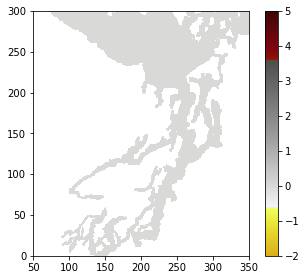

In [42]:
di = 300; dj=300
imin= 0; jmin = 50
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(ps_masked[:] - oc_bathy[:], cmap=cm.oxy_r, vmax=5., vmin=-2)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((imin, imin+di))
ax.set_xlim((jmin, jmin+dj))
plt.plot(180+0.5, 807+0.5, 'rx')
plt.plot(99+0.5, 867+0.5, 'rx')

print (lat[465, 226], lon[465, 226])
depth_check(ps_masked[:])

## Smooth

### (don't) Deep ends of Hood Canal and Dabob Bay

In [44]:
imin, imax = 50, 75
jmin, jmax = 140, 155
dps_bathy = np.copy(ps_bathy)
#for i in range(imin, imax):
#    for j in range(jmin, jmax):
#        if dps_bathy[i, j] < 5 and dps_bathy[i, j] > 0:
#            dps_bathy[i, j] = 5

### Main Smoothing

In [45]:
# lets smooth
ps_masked = np.ma.masked_array(dps_bathy, ps_bathy == 0)
max_dh_over_hbar = 0.8
sm_bathy = bathy_tools.smooth(ps_masked, max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

In [46]:
depth_check(sm_bathy[:])

### (don't) Extra Smooth Puget

In [47]:
# smooth to 0.7 in south most part of Puget Sound
imin, imax = 0, 100
jmin, jmax = 75, 175
#sm_masked = np.ma.masked_array(sm_bathy, sm_bathy == 0)
#max_dh_over_hbar = 0.7
smp_bathy = np.copy(sm_bathy[:])
#smp_bathy[imin:imax, jmin:jmax] = bathy_tools.smooth(sm_masked[imin:imax, jmin:jmax], max_norm_depth_diff=max_dh_over_hbar, smooth_factor=0.2)

## Add Shallow Jetty

In [48]:
sj_bathy = np.copy(smp_bathy[:])
ibase = 410
jbase = 295

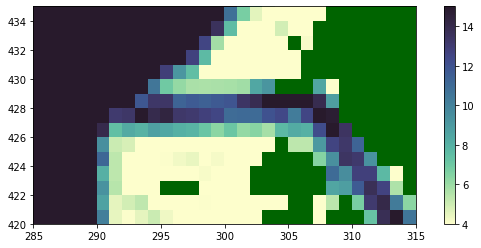

In [49]:
sj_masked = np.ma.masked_array(sj_bathy, sj_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 15
vmin = 4
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase+10, ibase+25))
ax.set_xlim((jbase-10, jbase+20));



In [50]:
x = np.arange(295, 304); jv_x = np.arange(295, 304); ju_x = []
y = np.ones(9)*429; jv_y = np.ones(9)*429; ju_y = []
print (x.shape, y.shape)


# make the jetty 4m deep
for j,i in zip(y, x):
    if sj_bathy[int(j), i] > 4:
        sj_bathy[int(j), i] = 4

(9,) (9,)


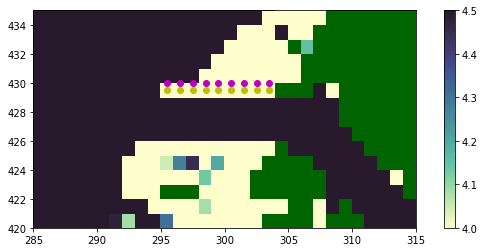

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax=4.5
vmin = 4
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase+10, ibase+25))
ax.set_xlim((jbase-10, jbase+20));

for j,i in zip(y,x):
    ax.plot(i+0.5, j+0.5, 'oy')
for j,i in zip(jv_y, jv_x):
    ax.plot(i+0.5, j+1, 'om')
for j,i in zip(ju_y, ju_x):
    ax.plot(i+1, j+0.5, 'xr')
#depth_check(sj_masked[:])

## Check Dredged Channel

In [52]:
dc_bathy = np.copy(sj_bathy[:])


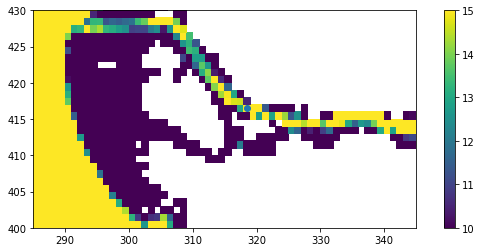

In [53]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 15
vmin = 10

viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase-10, ibase+20))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(jbase+23+0.5, ibase+6+0.5, 'o');


According to: https://voony.files.wordpress.com/2012/10/gmtnauticalchart.jpg

it should be at least 10 m above datum = 13 m above msl deep north of Deas. So I'll make it continuous 13 m throughout.


In [54]:
store_dc = np.copy(dc_bathy)

In [55]:
dc_bathy[ibase+3, jbase+49] = 13
dc_bathy[ibase+3, jbase+48] = 13
dc_bathy[ibase+4, jbase+48] = 13
dc_bathy[ibase+4, jbase+43] = 13
dc_bathy[ibase+5, jbase+43] = 13
dc_bathy[ibase+5, jbase+42] = 13
dc_bathy[ibase+5, jbase+41] = 13
dc_bathy[ibase+5, jbase+40] = 13
dc_bathy[ibase+5, jbase+39] = 13
dc_bathy[ibase+5, jbase+37] = 13
dc_bathy[ibase+4, jbase+37] = 13
dc_bathy[ibase+4, jbase+36] = 13
dc_bathy[ibase+4, jbase+35] = 13
dc_bathy[ibase+4, jbase+34] = 13
dc_bathy[ibase+4, jbase+33] = 13
dc_bathy[ibase+4, jbase+32] = 13
dc_bathy[ibase+4, jbase+31] = 13
dc_bathy[ibase+4, jbase+30] = 13
dc_bathy[ibase+4, jbase+29] = 13
dc_bathy[ibase+5, jbase+29] = 13
dc_bathy[ibase+5, jbase+28] = 13
dc_bathy[ibase+5, jbase+27] = 13
dc_bathy[ibase+6, jbase+27] = 13
dc_bathy[ibase+6, jbase+26] = 13
dc_bathy[ibase+6, jbase+25] = 13
dc_bathy[ibase+6, jbase+22] = 13
dc_bathy[ibase+7, jbase+22] = 13
dc_bathy[ibase+7, jbase+21] = 13
dc_bathy[ibase+7, jbase+20] = 13
dc_bathy[ibase+8, jbase+20] = 13
dc_bathy[ibase+8, jbase+19] = 13
dc_bathy[ibase+9, jbase+19] = 13
dc_bathy[ibase+9, jbase+18] = 13
dc_bathy[ibase+10, jbase+18] = 13
dc_bathy[ibase+10, jbase+17] = 13
dc_bathy[ibase+11, jbase+17] = 13
dc_bathy[ibase+11, jbase+16] = 13
dc_bathy[ibase+12, jbase+16] = 13
dc_bathy[ibase+13, jbase+16] = 13
dc_bathy[ibase+13, jbase+15] = 13
dc_bathy[ibase+14, jbase+15] = 13
dc_bathy[ibase+14, jbase+14] = 13
dc_bathy[ibase+15, jbase+14] = 13
dc_bathy[ibase+16, jbase+14] = 13
dc_bathy[ibase+16, jbase+13] = 13
dc_bathy[ibase+17, jbase+13] = 13
dc_bathy[ibase+17, jbase+12] = 13
dc_bathy[ibase+18, jbase+12] = 13
dc_bathy[ibase+18, jbase+7:jbase+12] = 13
dc_bathy[ibase+18, jbase+6] = 13
dc_bathy[ibase+18, jbase+5] = 13
dc_bathy[ibase+18, jbase+4] = 13
dc_bathy[ibase+18, jbase+3] = 13
dc_bathy[ibase+17, jbase+3] = 13
dc_bathy[ibase+17, jbase+2] = 13
dc_bathy[ibase+17, jbase+1] = 13
dc_bathy[ibase+17, jbase] = 13
dc_bathy[ibase+17, jbase-1] = 13
dc_bathy[ibase+17, jbase-2] = 13

In [56]:
dc_bathy = np.maximum(dc_bathy, store_dc)

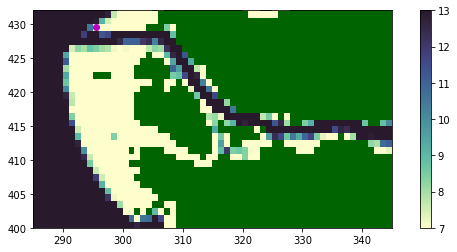

In [57]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 13
vmin = 7
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase-10, ibase+22))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(x[0]+0.5, y[0]+0.5, 'om');

### Put Canoe Pass Back

In [ ]:
# Not needed!
#dc_bathy[413, 298:303] = 4.
#dc_bathy[412, 298] = 4.

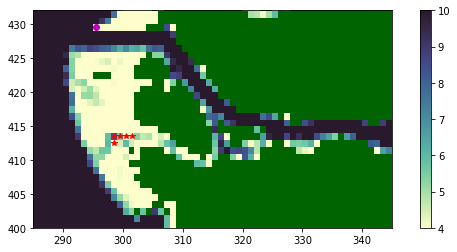

In [58]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 13
vmin = 7
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked, cmap=cmap, vmax=10, vmin=4)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase-10, ibase+22))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(x[0]+0.5, y[0]+0.5, 'om')
ax.plot(298.5, 412.5, 'r*')
ax.plot(np.arange(298.5, 302.5, 1), 413.5*np.ones(4), 'r*');

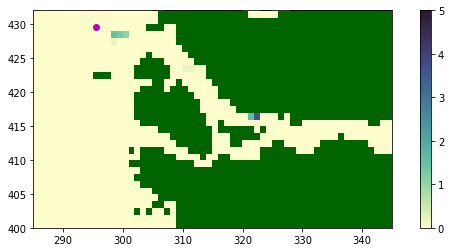

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

vmax= 5
vmin = 0
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(dc_masked-sj_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((ibase-10, ibase+22))
ax.set_xlim((jbase-10, jbase+50));
ax.plot(x[0]+0.5, y[0]+0.5, 'om')
depth_check(dc_masked[:])

### Middle Arm Connection

In [ ]:
# Not needed
#Fill = []
#for jj in range(313, 325):
#    for ii in range(430, 439):
#        Fill += [[jj+0.5, ii+0.5]]
#        if dc_bathy[ii, jj] > 4:
#            dc_bathy[ii, jj] = 4
#for jj in range(325, 329):
#    for ii in range(430, 436):
#        Fill += [[jj+0.5, ii+0.5]]
#        if dc_bathy[ii, jj] > 4:
#            dc_bathy[ii, jj] = 4
#Fill2 = [[329.5, 435.5], [326.5, 433.5]]
#dc_bathy[Fill2[0][1]-0.5, Fill2[0][0]-0.5] = 0.
#dc_bathy[Fill2[1][1]-0.5, Fill2[1][0]-0.5] = 0.
#dc_bathy[436:438, 316] = 4.

<ipython-input-60-7fb4fb6b88bc>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax[0].pcolormesh(lon, lat, dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)


(305.0, 345.0)

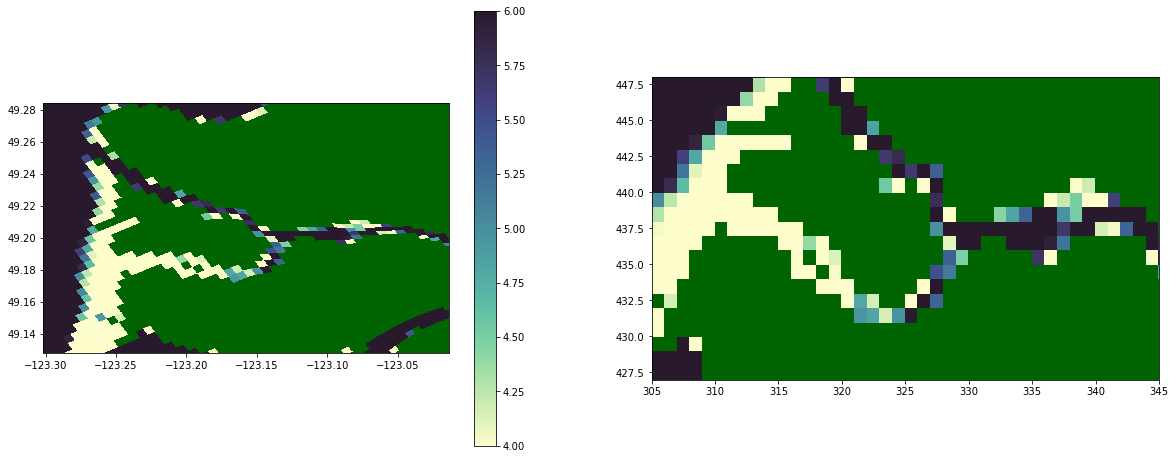

In [60]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0)
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
vmax= 6
vmin = 4
viz_tools.set_aspect(ax[0], coords='map')
viz_tools.set_aspect(ax[1], coords='grid')
mesh = ax[0].pcolormesh(lon, lat, dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
mesh = ax[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=ax[0])
ax[0].set_ylim((lat[ibase+27, jbase-10], lat[ibase+38, jbase+50]))
ax[0].set_xlim((lon[ibase+52, jbase+20], lon[ibase+17, jbase+50]))
ax[1].set_ylim((ibase+17, ibase+38))
ax[1].set_xlim((jbase+10, jbase+50))
#ax[1].plot([e1[0] for e1 in Fill], [e2[1] for e2 in Fill], 'ro')
#ax[1].plot([e1[0] for e1 in Fill2], [e2[1] for e2 in Fill2], 'y*')

### Spits, Ferry Terminal and Coal Port

<ipython-input-61-311ad28f42fa>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(lon[:], lat[:], dc_masked[:], cmap=cmap, vmax=20)


0.0058135986 0.0018386841


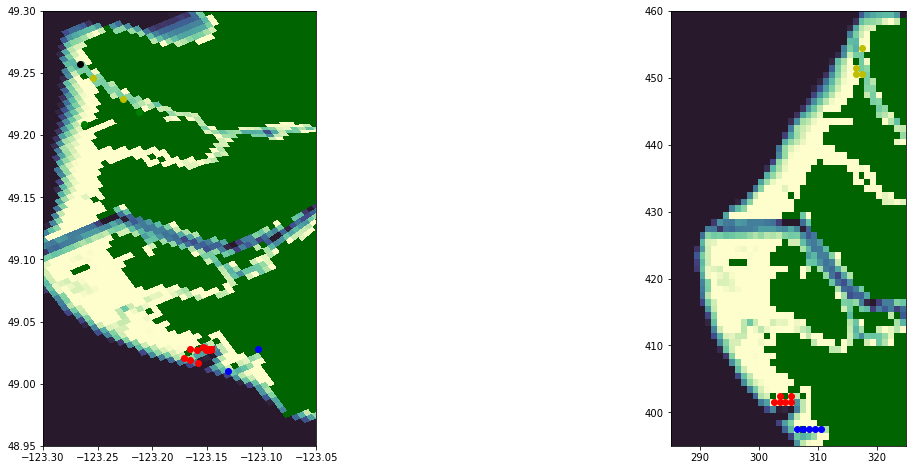

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
viz_tools.set_aspect(ax[0], coords='map')
viz_tools.set_aspect(ax[1])
ax[0].pcolormesh(lon[:], lat[:], dc_masked[:], cmap=cmap, vmax=20)
ax[1].pcolormesh(dc_masked[:], cmap=cmap, vmax=20)
ax[0].set_ylim((48.95, 49.3))
ax[0].set_xlim((-123.3, -123.05))
ax[1].set_ylim((395, 460))
ax[1].set_xlim((285, 325))
dlat = lat[430, 290] - lat[429, 289]
dlon = lon[430, 290] - lon[429, 289]
print(dlat, dlon)



# Tswassen Ferry Terminal
ax[0].plot(-123.132+dlon/2., 49.007+dlat/2., 'bo')
ax[0].plot(-123.104+dlon/2., 49.025+dlat/2., 'bo')
ax[1].plot(306+0.5, 397+0.5, 'bo')
ax[1].plot(307+0.5, 397+0.5, 'bo')
ax[1].plot(308+0.5, 397+0.5, 'bo')
ax[1].plot(309+0.5, 397+0.5, 'bo')
ax[1].plot(310+0.5, 397+0.5, 'bo')
dc_bathy[397, 306:311] = 0.

# Iona Spit
ax[0].plot(-123.263+dlon/2., 49.206+dlat/2., 'go')
ax[0].plot(-123.213+dlon/2., 49.216+dlat/2., 'go')
# Nothing to Do

# Iona/North Arm Spits
ax[0].plot(-123.255+dlon/2., 49.243+dlat/2., 'yo')
ax[0].plot(-123.228+dlon/2., 49.226+dlat/2., 'yo')
ax[0].plot(-123.267+dlon/2., 49.254+dlat/2., 'ko')
ax[1].plot(317+0.5, 450+0.5, 'yo')
ax[1].plot(316+0.5, 450+0.5, 'yo')
ax[1].plot(316+0.5, 451+0.5, 'yo')
ax[1].plot(317+0.5, 454+0.5, 'yo')
dc_bathy[450, 316:318] = 0.
dc_bathy[451, 316] = 0.
dc_bathy[454, 317] = 0.

# Coal Port
ax[0].plot(-123.153+dlon/2., 49.026+dlat/2., 'ro')
ax[0].plot(-123.152+dlon/2., 49.024+dlat/2., 'ro')
ax[0].plot(-123.147+dlon/2., 49.025+dlat/2., 'rs')
ax[0].plot(-123.159+dlon/2., 49.014+dlat/2., 'ro')
ax[0].plot(-123.166+dlon/2., 49.016+dlat/2., 'ro')
ax[0].plot(-123.172+dlon/2., 49.018+dlat/2., 'ro')
ax[0].plot(-123.166+dlon/2., 49.025+dlat/2., 'ro')
ax[0].plot(-123.160+dlon/2., 49.024+dlat/2., 'ro')
ax[0].plot(-123.148+dlon/2., 49.024+dlat/2., 'ro')
ax[0].plot(-123.155+dlon/2., 49.027+dlat/2., 'ro')

ax[1].plot(302+0.5, 401+0.5, 'ro')
ax[1].plot(303+0.5, 401+0.5, 'ro')
ax[1].plot(304+0.5, 401+0.5, 'ro')
ax[1].plot(305+0.5, 401+0.5, 'ro')
ax[1].plot(303+0.5, 402+0.5, 'ro')
ax[1].plot(305+0.5, 402+0.5, 'ro')
dc_bathy[401, 302:306] = 0.
dc_bathy[402, 303:306] = 0.
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);

## Changes for 202108 from 201803d

### 9.1 Connect Roche Harbour

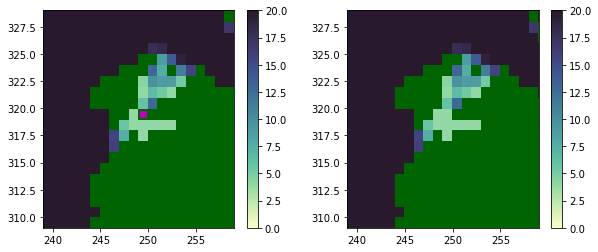

In [62]:
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((319-10, 319+10))
axs[0].set_xlim((249-10, 249+10));
axs[0].plot(249+0.5, 319+0.5, 'sm');

dc_bathy[319, 249] = 4

dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);


vmax= 20
vmin = 0
viz_tools.set_aspect(axs[1])
mesh = axs[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim((319-10, 319+10))
axs[1].set_xlim((249-10, 249+10));

depth_check(dc_masked[:])

### 9.2 Remove extra island on the mudflats

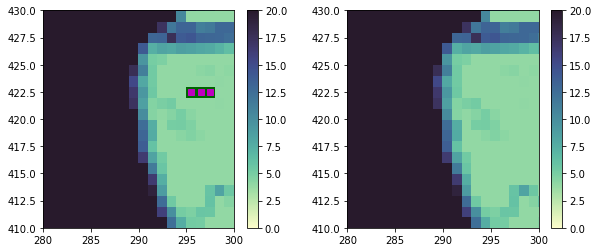

In [63]:
istart, iend = 410, 430
jstart, jend = 280, 300
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((istart, iend))
axs[0].set_xlim((jstart, jend));
axs[0].plot(np.arange(295, 298)+0.5, 422*np.ones((3))+0.5, 'sm');

dc_bathy[422, 295:298] = 4

dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);


vmax= 20
vmin = 0
viz_tools.set_aspect(axs[1])
mesh = axs[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim((istart, iend))
axs[1].set_xlim((jstart, jend));

depth_check(dc_masked[:])

### 9.3 Don't Close Read Island North End

In [ ]:
777 170 7.6875
777 171 4.0
778 170 8.4375
778 171 4.0
778 172 4.0
778 173 4.0
779 172 4.0
779 173 4.0
779 174 4.0
779 175 7.8125
780 174 5.875

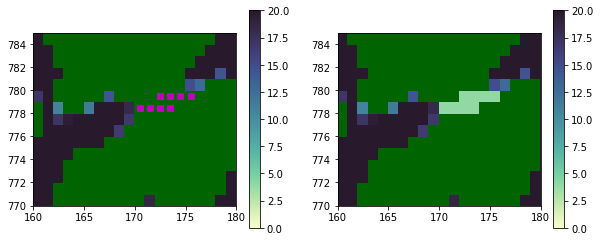

In [64]:
istart, iend = 770, 785
jstart, jend = 160, 180
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((istart, iend))
axs[0].set_xlim((jstart, jend));
pointsi = np.array([778, 778, 778, 778, 779, 779, 779, 779])
pointsj = np.array([170, 171, 172, 173, 172, 173, 174, 175])
axs[0].plot(pointsj+0.5, pointsi+0.5, 'sm');

dc_bathy[pointsi, pointsj] = 4.

dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[1])
mesh = axs[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim((istart, iend))
axs[1].set_xlim((jstart, jend));

### 9.4 Disconnect Stuart Island

In [ ]:
807 180 20.0625
808 180 14.9375
809 180 10.5
809 181 11.1875
810 180 19.5
810 181 22.125
810 182 22.9375

In [65]:
play = np.copy(dc_bathy)
play_masked = np.ma.masked_array(play, play == 0);

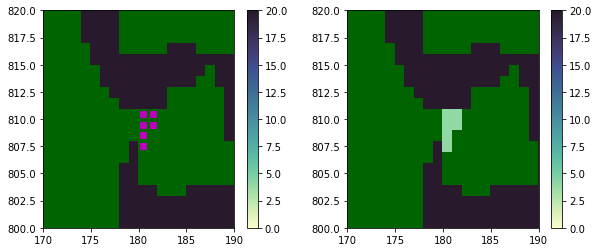

In [66]:
istart, iend = 800, 820
jstart, jend = 170, 190
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((istart, iend))
axs[0].set_xlim((jstart, jend));
pointsi = np.array([807, 808, 809, 809, 810, 810])
pointsj = np.array([180, 180, 180, 181, 180, 181])
axs[0].plot(pointsj+0.5, pointsi+0.5, 'sm');

dc_bathy[pointsi, pointsj] = 4.
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);


vmax= 20
vmin = 0
viz_tools.set_aspect(axs[1])
mesh = axs[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim((istart, iend))
axs[1].set_xlim((jstart, jend));

### 9.5 Deepen Tacoma Narrows
See SouthBasinBathymetry in analysis-susan

plt.plot(181-160, 22-5, 'ro')
plt.plot(178-160, 20-5, 'bo')
plt.plot(173-160, 18-5, 'ko')

In [ ]:
play = np.copy(dc_bathy)

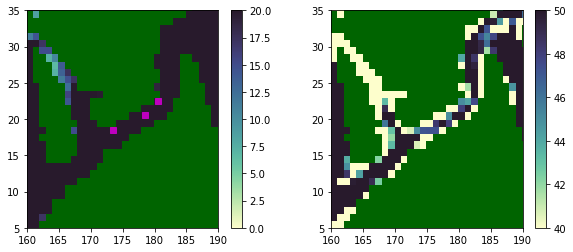

In [67]:
istart, iend = 5, 35
jstart, jend = 160, 190
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

vmax= 20
vmin = 0
viz_tools.set_aspect(axs[0])
mesh = axs[0].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim((istart, iend))
axs[0].set_xlim((jstart, jend));
pointsi = np.array([22, 20, 18])
pointsj = np.array([180, 178, 173])
axs[0].plot(pointsj+0.5, pointsi+0.5, 'sm');

dc_bathy[pointsi, pointsj] = 45.
dc_masked = np.ma.masked_array(dc_bathy, dc_bathy == 0);
#play[pointsi, pointsj] = 45.
#play_masked = np.ma.masked_array(play, play == 0);

vmax= 50
vmin = 40
viz_tools.set_aspect(axs[1])
mesh = axs[1].pcolormesh(dc_masked, cmap=cmap, vmax=vmax, vmin=vmin)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim((istart, iend))
axs[1].set_xlim((jstart, jend));

## Final Bathymetry

In [68]:
final_bathy = dc_masked

<ipython-input-69-0af98b408bd1>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[0].pcolormesh(lon[:], lat[:], md_bathy[:], cmap=cmap)
<ipython-input-69-0af98b408bd1>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = axs[1].pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap)


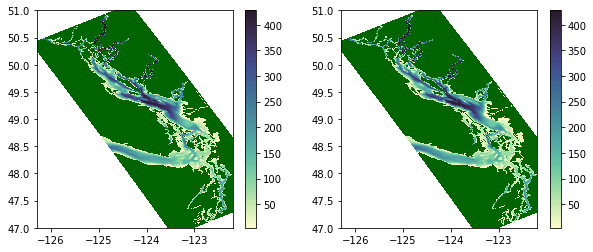

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
viz_tools.set_aspect(axs[0], coords='map')
mesh = axs[0].pcolormesh(lon[:], lat[:], md_bathy[:], cmap=cmap)
fig.colorbar(mesh, ax=axs[0])
axs[0].set_ylim(lon_limits)
axs[0].set_xlim(lat_limits)
viz_tools.set_aspect(axs[1], coords='map')
mesh = axs[1].pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap)
fig.colorbar(mesh, ax=axs[1])
axs[1].set_ylim(lon_limits)
axs[1].set_xlim(lat_limits);

<ipython-input-70-e8419eba031b>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(md_bathy[:]), cmap='bwr', vmax=20, vmin=-20)


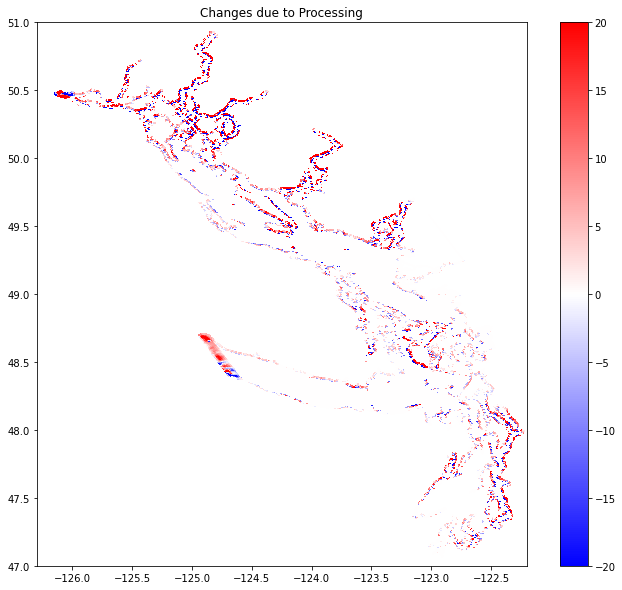

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(md_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_ylim(lon_limits)
ax.set_title('Changes due to Processing')
ax.set_xlim(lat_limits);

<ipython-input-71-87b28a8372ca>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(ss2_bathy[:]), cmap='bwr', vmax=20, vmin=-20)


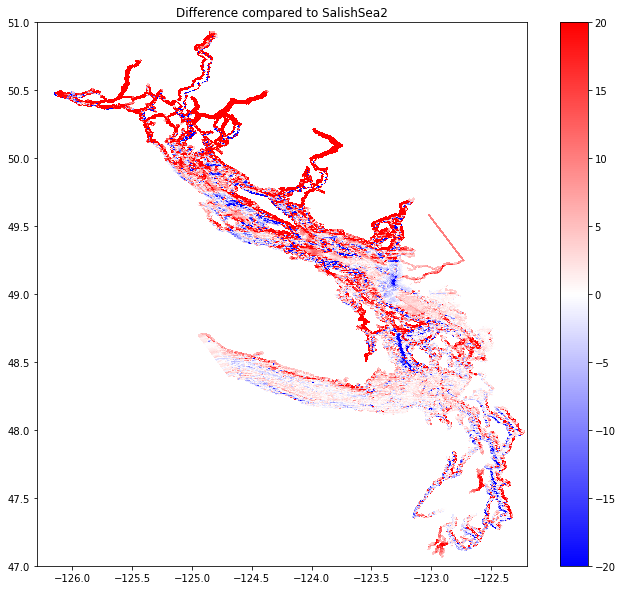

In [71]:
ss2_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/nemo-forcing/grid/bathy_meter_SalishSea2.nc')
ss2_bathy = ss2_file.variables['Bathymetry']
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(ss2_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to SalishSea2')
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
ss2_file.close()

<ipython-input-72-38add791e7ee>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(db1_bathy[:]), cmap='bwr', vmax=20, vmin=-20)


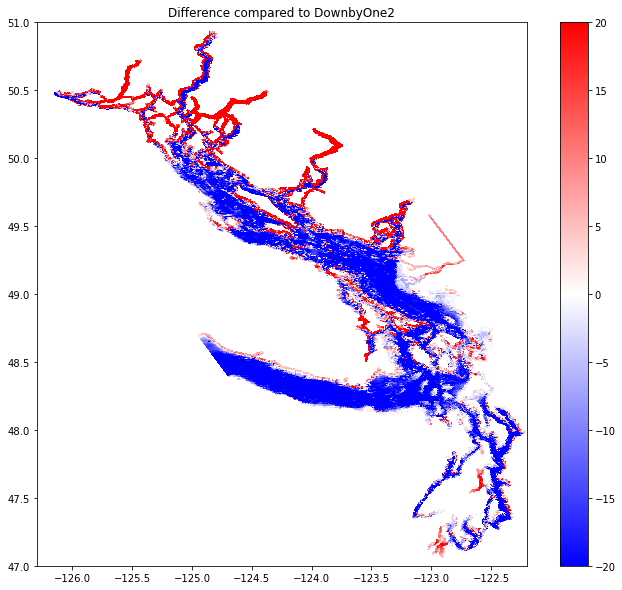

In [72]:
db1_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/nemo-forcing/grid/bathy_downonegrid2.nc')
db1_bathy = db1_file.variables['Bathymetry']
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-np.array(db1_bathy[:]), cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to DownbyOne2')
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
db1_file.close()

<ipython-input-73-b85d3c0a3bf6>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-tos_bathy, cmap='bwr', vmax=20, vmin=-20)


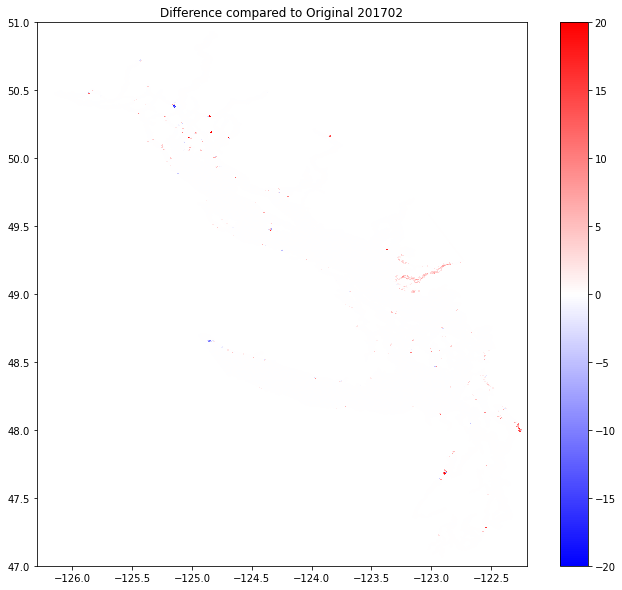

In [73]:
tos_file = nc.Dataset('/ocean/sallen/allen/research/MEOPAR/grid/bathymetry_201702.nc')
tos_bathy = tos_file.variables['Bathymetry'][:]
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy-tos_bathy, cmap='bwr', vmax=20, vmin=-20)
fig.colorbar(mesh, ax=ax)
ax.set_title('Difference compared to Original 201702')
ax.set_ylim(lon_limits)
ax.set_xlim(lat_limits)
db1_file.close()

<ipython-input-74-d8066bc978d7>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap ,vmax=25, vmin=4)


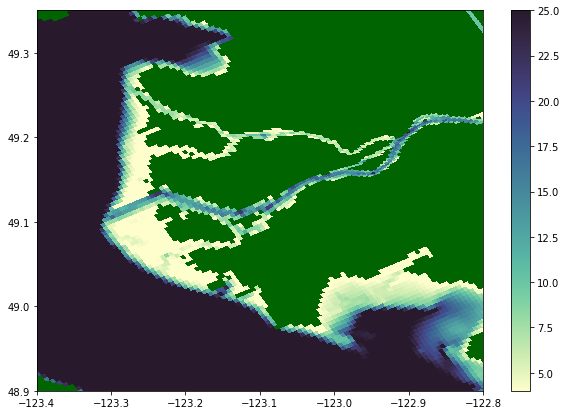

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:], cmap=cmap ,vmax=25, vmin=4)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((48.9, 49.35))
ax.set_xlim((-123.4, -122.8));

<ipython-input-75-d528d629bde8>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:]-md_bathy[:], cmap='bwr' ,vmax=5, vmin=-5)


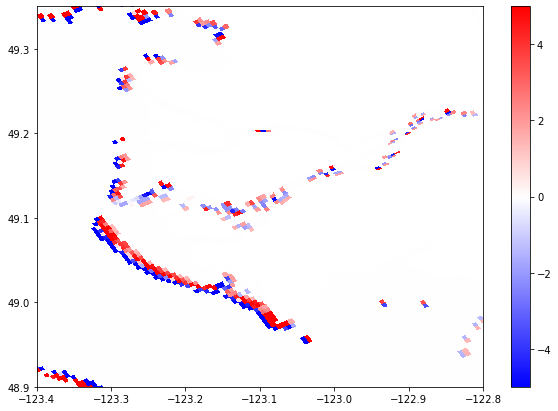

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
viz_tools.set_aspect(ax, coords='map')
mesh = ax.pcolormesh(lon[:], lat[:], final_bathy[:]-md_bathy[:], cmap='bwr' ,vmax=5, vmin=-5)
fig.colorbar(mesh, ax=ax)
ax.set_ylim((48.9, 49.35))
ax.set_xlim((-123.4, -122.8));

## Write out ##

In [76]:
nc_tools.show_dataset_attrs(md_bathyfile)

file format: NETCDF4


In [77]:
ysize = final_bathy.shape[0]; xsize = final_bathy.shape[1]
print (ysize, xsize)

898 398


In [78]:
bathy201803.close()

NameError: name 'bathy201803' is not defined

In [79]:
bathy201803 = nc.Dataset('./bathymetry_202108.nc', 'w')
bathy201803.createDimension('y', ysize)
bathy201803.createDimension('x', xsize)
nc_tools.show_dimensions(bathy201803)

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398


In [80]:
newlons = bathy201803.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlons.setncattr('long_name', 'longitude')
newlats = bathy201803.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newlats.setncattr('long_name', 'latitude')

newdepths = bathy201803.createVariable(
    'Bathymetry', float, ('y', 'x'),
    zlib=True, least_significant_digit=0.1, fill_value=0)
newdepths.setncattr('units', 'metres')
newdepths.setncattr('long_name', 'sea_floor_depth')

newlons[:] = lon[:]
newlats[:] = lat[:]
newdepths[:] = final_bathy[:]

In [81]:
print (final_bathy.max())

428.0


In [82]:
print (newlons)

<class 'netCDF4._netCDF4.Variable'>
float64 nav_lon(y, x)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used


In [83]:
nc_tools.init_dataset_attrs(bathy201803, 'Bathymetry 202108', 'Process202108Bathymetry',
                           'grid/bathymetry_202108.nc',
                            'Bathymetry processed from Michaels New Full River Bathymetry with 2m crit. bank but deeper river')

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry 202108
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2021-08-06 09:57:36] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry with 2m crit. bank but deeper river


In [84]:
bathy201803.setncattr('references', 'grid/bathymetry_202108.nc')
bathy201803.setncattr('source', 'bathymetry/Process202108Bathymetry.ipynb')

In [85]:
nc_tools.check_dataset_attrs(bathy201803)

In [86]:
nc_tools.show_dataset_attrs(bathy201803)

file format: NETCDF4
Conventions: CF-1.6
title: Bathymetry 202108
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: bathymetry/Process202108Bathymetry.ipynb
references: grid/bathymetry_202108.nc
history: [2021-08-06 09:57:36] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry with 2m crit. bank but deeper river


In [87]:
bathy201803.close()

## Jetty Mask ##

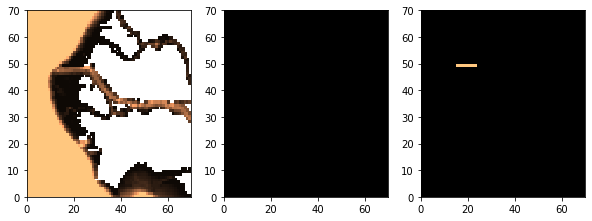

In [88]:
mask_for_jetty_u = np.zeros_like(ns_bathy)
mask_for_jetty_v = np.zeros_like(ns_bathy)
for j, i in zip(jv_y, jv_x):
    mask_for_jetty_v[int(j), int(i)]= 1.0
for j, i in zip(ju_y, ju_x):
    mask_for_jetty_u[j, i] = 1.0
fig, ax = plt.subplots(1, 3, figsize=(10,5))
viz_tools.set_aspect(ax[0])
viz_tools.set_aspect(ax[1])
viz_tools.set_aspect(ax[2])
ax[0].pcolormesh(final_bathy[380:450, 280:350], cmap='copper', vmax=25, vmin=3)
ax[1].pcolormesh(mask_for_jetty_u[380:450, 280:350], cmap='copper', vmax=1, vmin=0)
ax[2].pcolormesh(mask_for_jetty_v[380:450, 280:350], cmap='copper', vmax=1, vmin=0);

In [89]:
jetty_mask = nc.Dataset('./jetty_mask_bathy202108.nc', 'w')
jetty_mask.createDimension('y', ysize)
jetty_mask.createDimension('x', xsize)
nc_tools.show_dimensions(jetty_mask)

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398


In [90]:
newlons = jetty_mask.createVariable('nav_lon', float, ('y', 'x'), zlib=True)
newlons.setncattr('units', 'degrees_east')
newlons.setncattr('long_name', 'longitude')
newlats = jetty_mask.createVariable('nav_lat', float, ('y', 'x'), zlib=True)
newlats.setncattr('units', 'degrees_north')
newlats.setncattr('long_name', 'latitude')

friction_mask_u = jetty_mask.createVariable(
    'bfr_coef_u', float, ('y', 'x'),
    zlib=True, fill_value=-99)
friction_mask_u.setncattr('units', 'none')
friction_mask_u.setncattr('long_name', 'friction_x_binary_mask')
friction_mask_v = jetty_mask.createVariable(
    'bfr_coef_v', float, ('y', 'x'),
    zlib=True, fill_value=-99)
friction_mask_v.setncattr('units', 'none')
friction_mask_v.setncattr('long_name', 'friction_y_binary_mask')

In [93]:
newlons[:] = lon[:]
newlats[:] = lat[:]
friction_mask_u[:] = mask_for_jetty_u[:]
friction_mask_v[:] = mask_for_jetty_v[:]
print(np.min(mask_for_jetty_u))
print(np.max(friction_mask_v[:]))

0.0
1.0


In [94]:
nc_tools.init_dataset_attrs(jetty_mask, 'Jetty Mask for Bathy 202108', 'Process202108Bathymetry',
                           'grid/jetty_mask_bathy202108',
                            'Bathymetry processed from Michaels New Full River Bathymetry')

file format: NETCDF4
Conventions: CF-1.6
title: Jetty Mask for Bathy 202108
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: REQUIRED
references: REQUIRED
history: [2021-08-06 10:32:12] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry


In [96]:
jetty_mask.setncattr('references', 'grid/jetty_mask_bathy202108.nc')

In [97]:
jetty_mask.setncattr('source', 'bathymetry/Process202108Bathymetry.ipynb')

In [98]:
nc_tools.check_dataset_attrs(jetty_mask)

In [99]:
nc_tools.show_dataset_attrs(jetty_mask)

file format: NETCDF4
Conventions: CF-1.6
title: Jetty Mask for Bathy 202108
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: bathymetry/Process202108Bathymetry.ipynb
references: grid/jetty_mask_bathy202108.nc
history: [2021-08-06 10:32:12] Created netCDF4 zlib=True dataset.
comment: Bathymetry processed from Michaels New Full River Bathymetry


In [100]:
jetty_mask.close()